# Airline Food Demand Prediction System
**Team Name:** Vector_Team

This notebook contains the complete implementation of the Airline Food Demand Prediction project, including data generation, exploratory data analysis, and machine learning modeling.

## 1. Imports & Setup

In [8]:
# ============================================================================
# IMPORTS AND SETUP
# ============================================================================
# This section imports all necessary libraries for the project

# Data manipulation and analysis
import pandas as pd          # For working with dataframes and structured data
import numpy as np           # For numerical operations and array handling

# Data visualization
import matplotlib.pyplot as plt  # Core plotting library
import seaborn as sns           # Statistical data visualization built on matplotlib

# Machine learning and model evaluation
from sklearn.model_selection import train_test_split, GridSearchCV  # Data splitting and hyperparameter tuning
from sklearn.linear_model import LinearRegression                   # Linear regression model
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor  # Alternative model, bonus 3rd model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error  # Performance metrics

# Utility imports
from IPython.display import display  # Enhanced display for DataFrames
import os                            # File system operations

# ============================================================================
# CONFIGURATION
# ============================================================================
# Set visualization style for consistent, professional-looking plots
sns.set_theme(style='whitegrid')

# Create directory for saving plots (if it doesn't exist)
os.makedirs('plots', exist_ok=True)


## 2. Part 1: Data Generation
Generating a synthetic dataset with 5,000 records and specific constraints.

In [9]:
# ============================================================================
# DATA GENERATION MODULE
# ============================================================================
# This module generates synthetic airline flight data that mimics real world
# conditions for training machine learning models

def generate_airline_data(n_rows=5000):
    """
    Generate synthetic airline flight dataset with realistic relationships.
    
    The target variable (total_food_demand) depends on multiple features:
    1. flight_duration - Longer flights need more meals/snacks
    2. is_international - International flights serve more food
    3. business_class_ratio - Business class passengers get more food
    4. child_passengers - Children typically eat less
    
    Parameters:
    -----------
    n_rows : int
        Number of flight records to generate (default: 5000)
    
    Returns:
    --------
    pd.DataFrame
        Dataset with 8 features and 1 target variable
    """
    # Set random seed for reproducibility
    np.random.seed(42)
    
    # ========================================================================
    # FEATURE 1: Flight ID (Identifier only, not used for prediction)
    # ========================================================================
    flight_ids = np.arange(1, n_rows + 1)
    
    # ========================================================================
    # FEATURE 2: Passenger Count (50-300 passengers per flight)
    # ========================================================================
    passenger_counts = np.random.randint(50, 301, size=n_rows)
    
    # ========================================================================
    # FEATURES 3 & 4: Adult and Child Passengers
    # Must sum to passenger_count (Validation Rule #1)
    # ========================================================================
    adult_passengers = []
    child_passengers = []
    for count in passenger_counts:
        # Adults typically make up 70-100% of passengers
        adult = np.random.randint(int(count * 0.7), count + 1)
        adult_passengers.append(adult)
        # Remaining passengers are children
        child_passengers.append(count - adult)
    
    adult_passengers = np.array(adult_passengers)
    child_passengers = np.array(child_passengers)
    
    # ========================================================================
    # FEATURE 5: International vs Domestic Flights
    # 20% international, 80% domestic (satisfies 15% minimum requirement)
    # ========================================================================
    is_international = np.random.choice([0, 1], size=n_rows, p=[0.8, 0.2])
    
    # ========================================================================
    # FEATURE 6: Flight Duration (hours)
    # International flights: 3-12 hours (Validation Rule #4)
    # Domestic flights: 1-8 hours
    # ========================================================================
    flight_durations = []
    for inter in is_international:
        if inter == 1:
            # International: minimum 3 hours
            duration = np.random.uniform(3, 12)
        else:
            # Domestic: 1-8 hours
            duration = np.random.uniform(1, 8)
        flight_durations.append(round(duration, 2))
    
    flight_durations = np.array(flight_durations)
    
    # ========================================================================
    # FEATURE 7: Business Class Ratio (0.0 to 1.0)
    # Represents proportion of business class passengers
    # ========================================================================
    business_class_ratios = np.random.uniform(0, 1.0, size=n_rows)
    
    # ========================================================================
    # TARGET VARIABLE: Total Food Demand
    # Complex formula depending on multiple features
    # ========================================================================
    total_food_demand = []
    base_meals_per_passenger = 1.0  # Base assumption: 1 meal per passenger
    
    for i in range(n_rows):
        # Get current row's features
        dur = flight_durations[i]
        inter = is_international[i]
        biz_ratio = business_class_ratios[i]
        p_count = passenger_counts[i]
        c_count = child_passengers[i]
        
        # FACTOR 1: Flight duration effect
        # Short flights (<2h): 80% of base (light snack)
        # Medium flights (2h-4h): 100% of base (one meal)
        # Long flights (4h-8h): 150% of base (meal + snacks)
        # Very long flights (8h+): 200% of base (two meals + snacks)
        if dur < 2: 
            duration_multiplier = 0.8
        elif dur < 4: 
            duration_multiplier = 1.0
        elif dur < 8: 
            duration_multiplier = 1.5
        else: 
            duration_multiplier = 2.0
        
        # FACTOR 2: International flight bonus
        # International flights serve 30% more food
        international_bonus = 0.3 if inter == 1 else 0.0
        
        # FACTOR 3: Business class bonus
        # Business class passengers receive 40% more food (scaled by ratio)
        business_bonus = biz_ratio * 0.4
        
        # FACTOR 4: Child passenger reduction
        # Children eat approximately 15% less than adults
        child_ratio = c_count / p_count
        child_reduction = child_ratio * 0.15
        
        # Calculate food per passenger with all factors
        food_per_passenger = base_meals_per_passenger * duration_multiplier * (1 + international_bonus + business_bonus - child_reduction)
        
        # Add random noise (+/- 5%) for realism
        # Real world demand has natural variability
        noise_factor = np.random.uniform(0.95, 1.05)
        demand = round(p_count * food_per_passenger * noise_factor)
        
        # Ensure minimum constraint (Validation Rule #6)
        # At least 50% of passengers receive food
        demand = max(demand, int(p_count * 0.5))
        
        total_food_demand.append(demand)
    
    # ========================================================================
    # Create DataFrame with all features
    # ========================================================================
    df = pd.DataFrame({
        'flight_id': flight_ids,
        'flight_duration': flight_durations,
        'passenger_count': passenger_counts,
        'adult_passengers': adult_passengers,
        'child_passengers': child_passengers,
        'business_class_ratio': business_class_ratios,
        'is_international': is_international,
        'total_food_demand': total_food_demand
    })
    
    return df


def validate_dataset(df):
    """
    Validate that the generated dataset satisfies all 9 project requirements.
    
    Parameters:
    -----------
    df : pd.DataFrame
        The dataset to validate
    
    Returns:
    --------
    bool
        True if all validation checks pass, False otherwise
    """
    checks = []
    
    # Validation Rule #1: Adult + child passengers must equal total passengers
    checks.append((
        "adult + child = total",
        (df['adult_passengers'] + df['child_passengers'] == df['passenger_count']).all()
    ))
    
    # Validation Rule #2: Business class ratio must be between 0 and 1
    checks.append((
        "business_ratio [0,1]",
        ((df['business_class_ratio'] >= 0) & (df['business_class_ratio'] <= 1)).all()
    ))
    
    # Validation Rule #3: Flight duration must be between 1 and 12 hours
    checks.append((
        "duration [1,12]",
        ((df['flight_duration'] >= 1) & (df['flight_duration'] <= 12)).all()
    ))
    
    # Validation Rule #4: International flights must be at least 3 hours
    checks.append((
        "international >= 3h",
        (df[df['is_international'] == 1]['flight_duration'] >= 3).all()
    ))
    
    # Validation Rule #5: Passenger count must be between 50 and 300
    checks.append((
        "passenger_count [50,300]",
        ((df['passenger_count'] >= 50) & (df['passenger_count'] <= 300)).all()
    ))
    
    # Validation Rule #6: Food demand must be at least 50% of passenger count
    checks.append((
        "food_demand >= 0.5*p",
        (df['total_food_demand'] >= df['passenger_count'] * 0.5).all()
    ))
    
    # Validation Rule #7: Dataset must have at least 5000 rows
    checks.append((
        "5000+ rows",
        len(df) >= 5000
    ))
    
    # Validation Rule #8: At least 15% of flights must be international
    checks.append((
        "15%+ international",
        (df['is_international'].sum() / len(df)) >= 0.15
    ))
    
    # Print validation results
    print("Validation Results:")
    for name, res in checks:
        status = '✓' if res else '✗'
        print(f"{status} {name}")
    
    # Return True only if all checks pass
    return all(r for n, r in checks)


# ============================================================================
# GENERATE AND VALIDATE DATASET
# ============================================================================
# Generate 5000 flight records
df = generate_airline_data(5000)

# Validate that all rules are satisfied
validate_dataset(df)

# Save dataset to CSV file for submission
df.to_csv('Vector_Team_dataset.csv', index=False)


Validation Results:
✓ adult + child = total
✓ business_ratio [0,1]
✓ duration [1,12]
✓ international >= 3h
✓ passenger_count [50,300]
✓ food_demand >= 0.5*p
✓ 5000+ rows
✓ 15%+ international


## 3. Part 2: EDA
Visualizing data distributions and correlations.

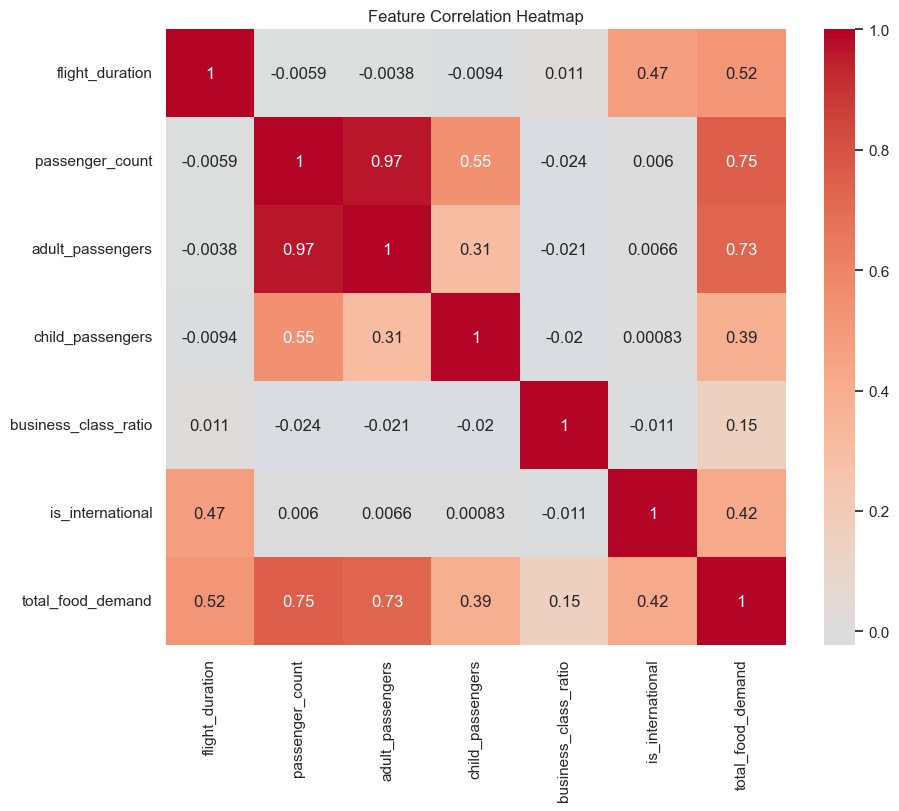

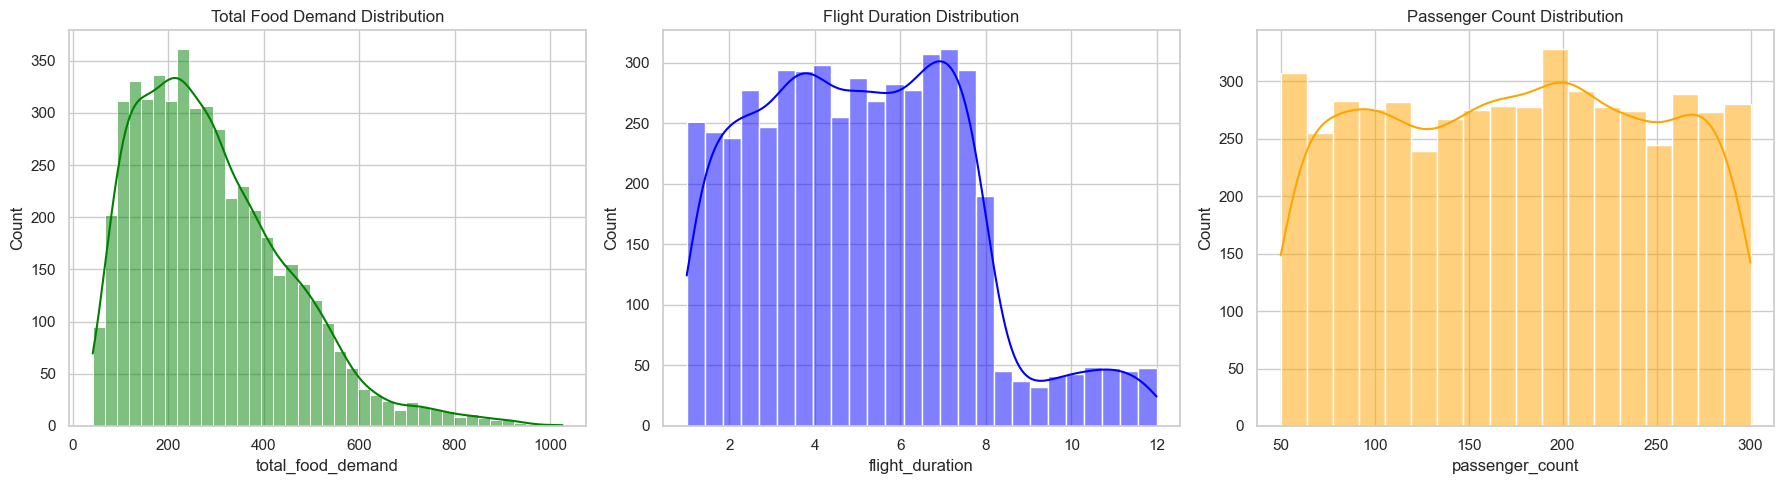

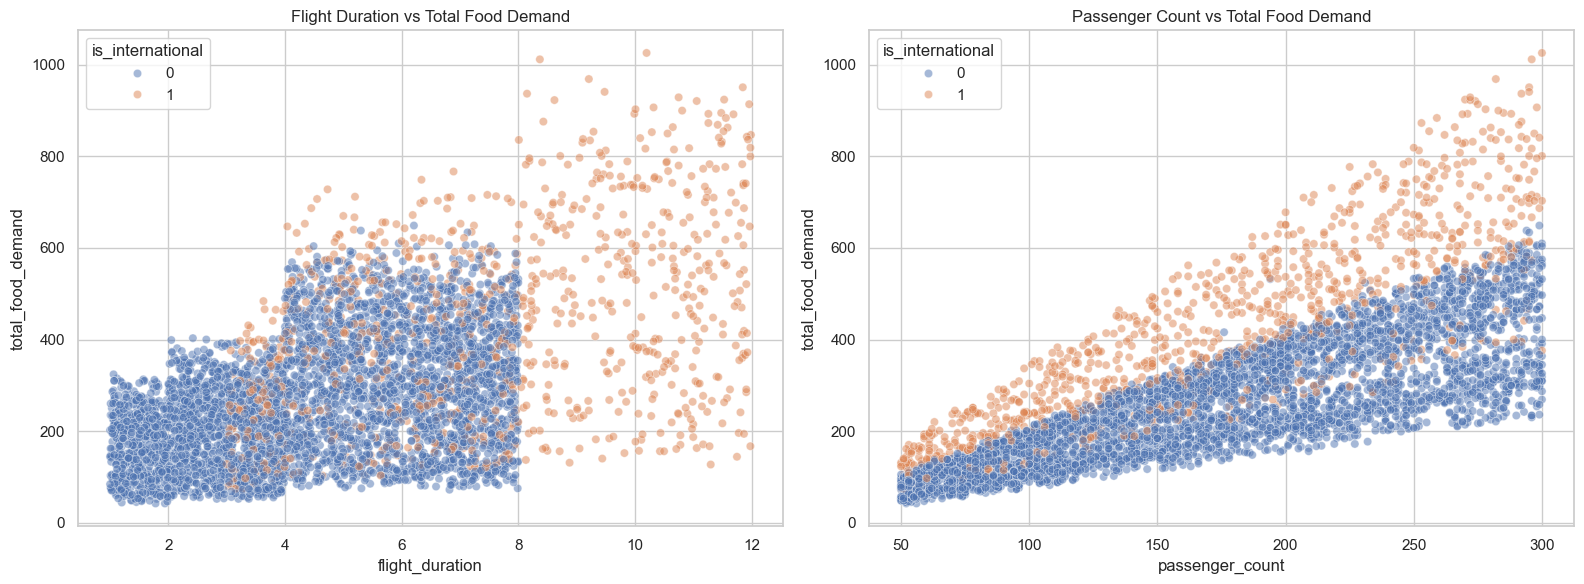

In [10]:
# ============================================================================
# EXPLORATORY DATA ANALYSIS (EDA)
# ============================================================================
# This section creates visualizations to understand data patterns and
# relationships between features and the target variable

# ============================================================================
# VISUALIZATION 1: Correlation Heatmap
# Shows relationships between all numerical features
# ============================================================================
plt.figure(figsize=(10, 8))
# Drop flight_id as it's just an identifier, not a predictive feature
sns.heatmap(
    df.drop('flight_id', axis=1).corr(),  # Calculate correlation matrix
    annot=True,      # Display correlation values in cells
    cmap='coolwarm', # Color scheme: blue (negative) to red (positive)
    center=0         # Center colormap at zero
)
plt.title('Feature Correlation Heatmap')
plt.savefig('plots/correlation_heatmap.png')
plt.show()

# ============================================================================
# VISUALIZATION 2: Feature Distributions
# Understanding the distribution of key variables
# ============================================================================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Target variable distribution
sns.histplot(df['total_food_demand'], kde=True, ax=axes[0], color='green')
axes[0].set_title('Total Food Demand Distribution')

# Flight duration distribution
sns.histplot(df['flight_duration'], kde=True, ax=axes[1], color='blue')
axes[1].set_title('Flight Duration Distribution')

# Passenger count distribution
sns.histplot(df['passenger_count'], kde=True, ax=axes[2], color='orange')
axes[2].set_title('Passenger Count Distribution')

plt.tight_layout()
plt.savefig('plots/distributions.png')
plt.show()

# ============================================================================
# VISUALIZATION 3: Scatter Plots (Feature vs Target)
# Examining relationships with the target variable
# Color-coded by flight type (domestic vs international)
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Flight duration vs food demand
# Expect positive correlation: longer flights = more food
sns.scatterplot(
    data=df, 
    x='flight_duration', 
    y='total_food_demand', 
    hue='is_international',  # Color by flight type
    alpha=0.5,               # Transparent points for better visualization
    ax=axes[0]
)
axes[0].set_title('Flight Duration vs Total Food Demand')

# Passenger count vs food demand
# Expect strong positive correlation: more passengers = more food
sns.scatterplot(
    data=df, 
    x='passenger_count', 
    y='total_food_demand', 
    hue='is_international',
    alpha=0.5,
    ax=axes[1]
)
axes[1].set_title('Passenger Count vs Total Food Demand')

plt.tight_layout()
plt.savefig('plots/scatter_plots.png')
plt.show()


## 4. Part 3: Modeling
Training and evaluating multiple regression models with hyperparameter tuning.

In [11]:
# ============================================================================
# MODEL TRAINING AND COMPARISON
# ============================================================================
# This section implements and compares multiple regression models:
# 1. Baseline (Mean Predictor)
# 2. Linear Regression
# 3. Random Forest with hyperparameter tuning
# 4. Gradient Boosting with hyperparameter tuning

# ============================================================================
# DATA PREPARATION
# ============================================================================
# Separate features (X) from target variable (y)
# IMPORTANT: Exclude flight_id (it's an identifier, not predictive as said in document)
X = df.drop(['flight_id', 'total_food_demand'], axis=1)
y = df['total_food_demand']

# Split data into training (80%) and testing (20%) sets
# random_state=42 ensures reproducibility
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,    # 20% for testing
    random_state=42   # Fixed seed for reproducibility
)

# List to store results from all models
results = []

# ============================================================================
# MODEL 1: BASELINE (Mean Predictor)
# ============================================================================
# Purpose: Establish minimum performance threshold
# Predicts the training set mean for all test samples
# If ML models can't beat this, they haven't learned anything useful
y_pred_baseline = np.full_like(y_test, y_train.mean())

# Calculate performance metrics
results.append({
    'Model': 'Baseline',
    'R2': r2_score(y_test, y_pred_baseline),
    'MAE': mean_absolute_error(y_test, y_pred_baseline),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_baseline))
})

# ============================================================================
# MODEL 2: LINEAR REGRESSION
# ============================================================================
# Simple linear model
# Assumes linear relationships between features and target
lr = LinearRegression()
lr.fit(X_train, y_train)  # Train on training data only
y_pred_lr = lr.predict(X_test)  # Predict on test data

# Calculate performance metrics
results.append({
    'Model': 'Linear Regression',
    'R2': r2_score(y_test, y_pred_lr),
    'MAE': mean_absolute_error(y_test, y_pred_lr),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_lr))
})

# ============================================================================
# MODEL 3: RANDOM FOREST (with Hyperparameter Tuning) - BONUS
# ============================================================================
# Random Forest: Collection of decision trees
# Advantages: Captures nonlinear relationships, protects against outliers
# Hyperparameters to tune:
# n_estimators: Number of trees (more trees = better but slower)
# max_depth: Maximum tree depth (None = unlimited depth)
rf_params = {
    'n_estimators': [100, 200],      # Try 100 and 200 trees
    'max_depth': [None, 10]          # Try unlimited and depth=10
}

# GridSearchCV tries all parameter combinations and picks the best
rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    rf_params,
    cv=3
)
rf_grid.fit(X_train, y_train)  # Find best parameters on training data

# Get the best model
best_rf = rf_grid.best_estimator_
y_pred_rf = best_rf.predict(X_test)

# Calculate performance metrics
results.append({
    'Model': 'Random Forest',
    'R2': r2_score(y_test, y_pred_rf),
    'MAE': mean_absolute_error(y_test, y_pred_rf),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_rf))
})

# ============================================================================
# MODEL 4: GRADIENT BOOSTING (with Hyperparameter Tuning) - BONUS
# ============================================================================
# Gradient Boosting: Sequential collection method
# Each tree corrects errors of previous trees
# Typically achieves excellent performance but requires tuning
gb_params = {
    'n_estimators': [100, 200],          # Number of boosting stages
    'learning_rate': [0.05, 0.1, 0.2],   # Step size for each tree
    'max_depth': [3, 5]                  # Depth of individual trees
}

# GridSearchCV with MSE as scoring metric
gb_grid = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    gb_params,
    cv=3,                              
    scoring='neg_mean_squared_error'   # Minimize MSE
)
gb_grid.fit(X_train, y_train)

# Get the best model
best_gb = gb_grid.best_estimator_
y_pred_gb = best_gb.predict(X_test)

# Calculate performance metrics
results.append({
    'Model': 'Gradient Boosting',
    'R2': r2_score(y_test, y_pred_gb),
    'MAE': mean_absolute_error(y_test, y_pred_gb),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_gb))
})

# ============================================================================
# MODEL COMPARISON TABLE
# ============================================================================
# Create DataFrame for easy comparison
results_df = pd.DataFrame(results)

# Display with styling: highlight best performance
# Green = best (highest R2, lowest MAE/RMSE)
display(results_df.style
    .highlight_min(subset=['MAE', 'RMSE'], color='darkgreen')  # Lower is better
    .highlight_max(subset=['R2'], color='darkgreen')           # Higher is better
    .format("{:.4f}", subset=['R2', 'MAE', 'RMSE']))            # 4 decimal places


,Model,R2,MAE,RMSE
0,Baseline,-0.0000,128.8000,163.7801
1,Linear Regression,0.8998,40.6585,51.8473
2,Random Forest,0.9946,8.7803,12.0076
3,Gradient Boosting,0.9944,8.9177,12.2884


## 5. Part 4: Evaluation
Comparing model performance and business impact.

C:\Users\oswin\AppData\Local\Temp\ipykernel_28436\606645569.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Total Cost ($)', data=costs, palette='viridis')


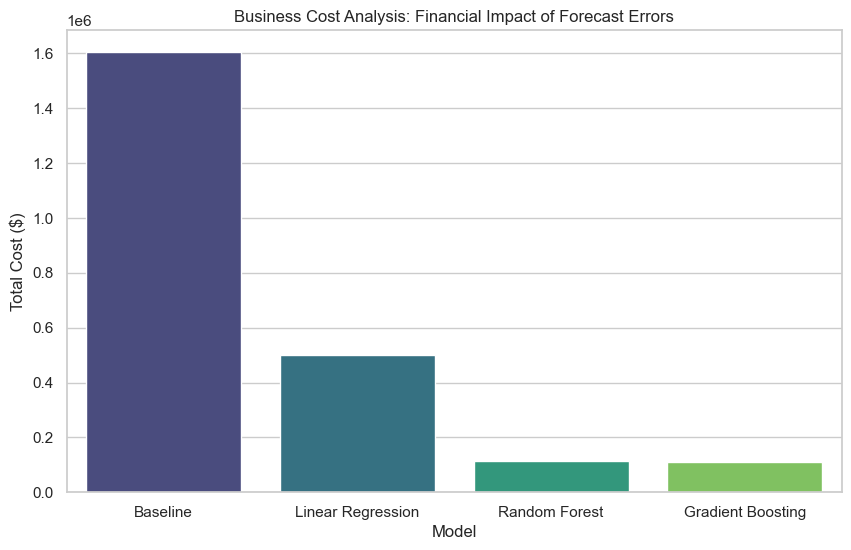

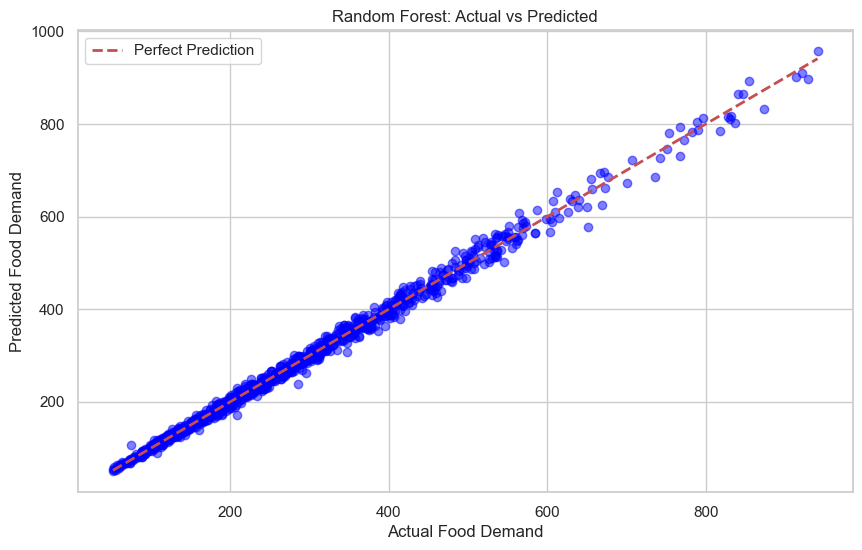

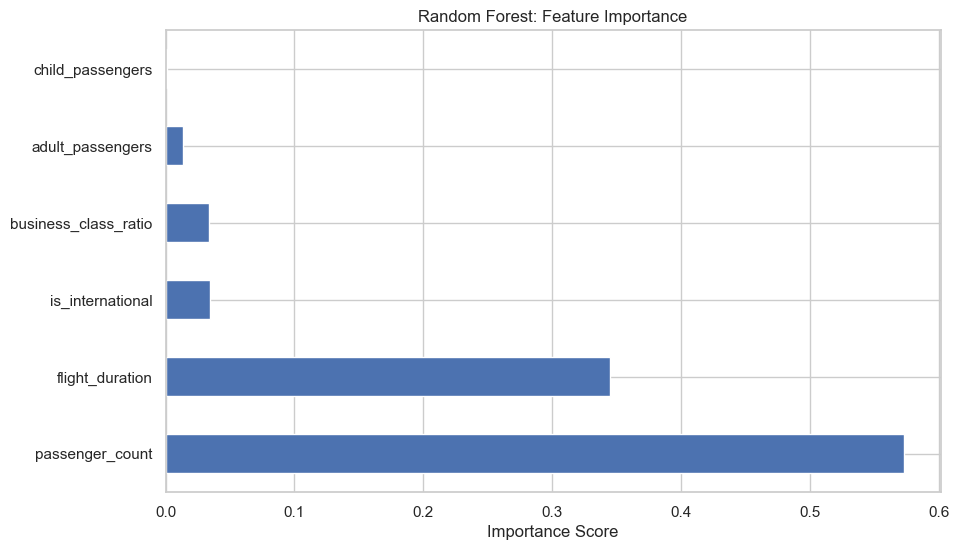

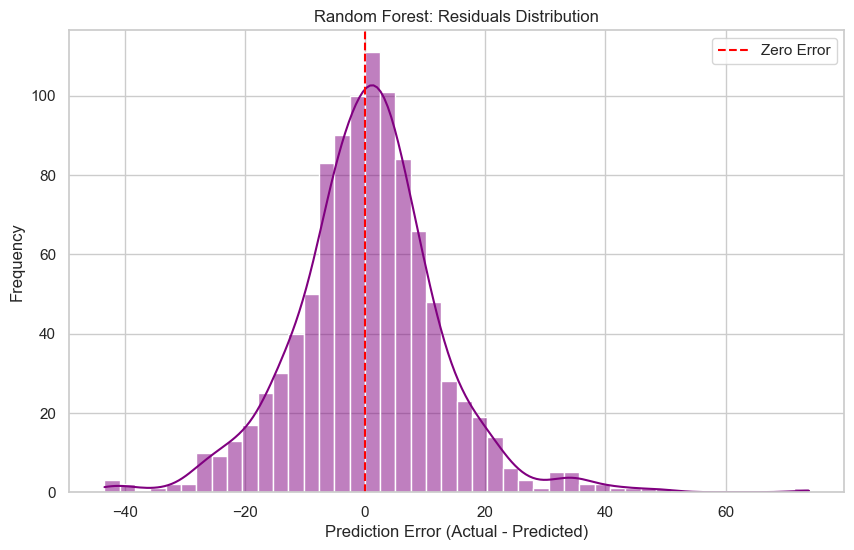

In [12]:
# ============================================================================
# MODEL EVALUATION AND BUSINESS ANALYSIS
# ============================================================================

# ============================================================================
# BUSINESS COST ANALYSIS - BONUS
# ============================================================================
# Calculate financial impact of prediction errors
def calculate_cost(actual, predicted):
    """
    Calculate total business cost of prediction errors.
    
    Parameters:
    -----------
    actual : array-like
        Actual food demand values
    predicted : array-like
        Predicted food demand values
    
    Returns:
    --------
    float
        Total cost in dollars
    """
    errors = predicted - actual
    
    # Cost of waste: $5 per unit
    over = np.sum(errors[errors > 0] * 5)
    
    # Cost of shortage: $20 per unit
    # Higher cost because passenger dissatisfaction is more expensive
    under = np.sum(np.abs(errors[errors < 0]) * 20)
    
    return over + under

# Calculate costs for all models
costs = pd.DataFrame({
    'Model': ['Baseline', 'Linear Regression', 'Random Forest', 'Gradient Boosting'],
    'Total Cost ($)': [
        calculate_cost(y_test, y_pred_baseline),
        calculate_cost(y_test, y_pred_lr),
        calculate_cost(y_test, y_pred_rf),
        calculate_cost(y_test, y_pred_gb)
    ]
})

# Visualize business costs
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Total Cost ($)', data=costs, palette='viridis')
plt.title('Business Cost Analysis: Financial Impact of Forecast Errors')
plt.ylabel('Total Cost ($)')
plt.savefig('plots/business_cost_analysis.png')
plt.show()

# ============================================================================
# VISUALIZATION 1: Actual vs Predicted (Best Model = Random Forest)
# ============================================================================
# Points should cluster around the red diagonal line for good predictions
# Deviations indicate prediction errors
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5, color='blue')
# Diagonal reference line: perfect predictions would fall exactly on this line
plt.plot([y_test.min(), y_test.max()], 
        [y_test.min(), y_test.max()], 
        'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Food Demand')
plt.ylabel('Predicted Food Demand')
plt.title('Random Forest: Actual vs Predicted')
plt.legend()
plt.savefig('plots/rf_actual_vs_predicted.png')
plt.show()

# ============================================================================
# VISUALIZATION 2: Feature Importance (Random Forest)
# ============================================================================
# Shows which features contribute most to predictions
# Higher importance = more influential in model decisions
importances = best_rf.feature_importances_
feat_importances = pd.Series(importances, index=X.columns)

plt.figure(figsize=(10, 6))
feat_importances.nlargest(10).plot(kind='barh')  # Top 10 features
plt.title('Random Forest: Feature Importance')
plt.xlabel('Importance Score')
plt.savefig('plots/feature_importance.png')
plt.show()

# ============================================================================
# VISUALIZATION 3: Residuals Distribution
# ============================================================================
# Prediction errors = Actual - Predicted
# Should be normally distributed around zero for good model
# Large prediction errors indicate poor predictions for those samples
residuals = y_test - y_pred_rf

plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='purple')
plt.axvline(x=0, color='red', linestyle='--', label='Zero Error')  # Add reference line at zero
plt.title('Random Forest: Residuals Distribution')
plt.xlabel('Prediction Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('plots/residuals_distribution.png')
plt.show()
